# Random Forest Model for Climate Change Predictions

We use a random forest model to predict to predict temperature, diurnal temperature range, precipitation, and 90th percentile precipitation from mean global temperature.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from eofs.xarray import Eof

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
# convert from kg/m^2/s to mm/day
KGM2S_TO_MMDAY = 86400

In [3]:
# variables to predict
output_vars = ['tas', 'diurnal_temperature_range', 'pr', 'pr90']

In [4]:
# Utilities for normalizing the emissions data
min_co2 = 0.
max_co2 = 2400
def normalize_co2(data):
    return data / max_co2

min_ch4 = 0.
max_ch4 = 0.6
def normalize_ch4(data):
    return data / max_ch4

### Create Training Data
First, we create the training for our model. We train our model using 6 scenarios: historical, ssp126, ssp370, and ssp585, hist-aer, and hist-GHG.

In [5]:
scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585', 'hist-aer', 'hist-GHG']

In [6]:
Xtrain = xr.concat(
    [xr.open_dataset(f'train_val/inputs_{s}.nc') for s in scenarios]
    , dim='time')

# average data over ensemble members
Ytrain = xr.concat(
    [xr.open_dataset(f'train_val/outputs_{s}.nc').mean('member') for s in scenarios]
    , dim='time')

In [7]:
# convert precipitation data to mm/day
Ytrain['pr'] *= KGM2S_TO_MMDAY
Ytrain['pr90'] *= KGM2S_TO_MMDAY

# add year data to X and Y
Xtrain["time"]=np.arange(1, 754)
Ytrain["time"]=np.arange(1, 754)

### Process Training Data
We perform EoF analysis (PCA) on the aerosol data to reduce the dimensionality to the first 5 principal dimensions, and we normalize the GHG emission data. We process the inputs so they can be used for training the random forest model.
The following code for normalizing the GHG data and performing EoF on the aerosol data is taken verbatim from Original_RF_model.ipynb.

In [8]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
bc_solver = Eof(Xtrain['BC'])
so2_solver = Eof(Xtrain['SO2'])

In [9]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
bc_eofs = bc_solver.eofsAsCorrelation(neofs=5)
bc_pcs = bc_solver.pcs(npcs=5, pcscaling=1)

so2_eofs = so2_solver.eofsAsCorrelation(neofs=5)
so2_pcs = so2_solver.pcs(npcs=5, pcscaling=1)

In [10]:
# Convert the Principle Components of the aerosol emissions (calculated above) in to Pandas DataFrames
bc_df = bc_pcs.to_dataframe().unstack('mode')
bc_df.columns = [f"BC_{i}" for i in range(5)]

so2_df = so2_pcs.to_dataframe().unstack('mode')
so2_df.columns = [f"SO2_{i}" for i in range(5)]

In [11]:
# Bring the emissions data back together again and normalize
leading_historical_inputs = pd.DataFrame({
    "CO2": normalize_co2(Xtrain["CO2"].data),
    "CH4": normalize_ch4(Xtrain["CH4"].data)
}, index=Xtrain["CO2"].coords['time'].data)

In [12]:
# format Xtrain and ytrain to be used for random forest model
Xinput = pd.concat([leading_historical_inputs, bc_df, so2_df], axis=1).to_numpy()

Yinput = {}
for out in output_vars:
    Yinput[out] = Ytrain[out].stack(dim=['lat','lon']).to_numpy()

### Fit Random Forest Model
We fit a random forest to the processed data.

In [13]:
# taken verbatim from Original_RF_model.ipynb
# parameters & hyperparameters for model

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,55, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 25]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 12]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [14]:
# dictionary to hold all 4 random forest models
random_forest_regressors = {out: RandomForestRegressor(random_state=0) for out in output_vars}

# create rscvs for each model
RSCVs = {out: RandomizedSearchCV(
        estimator = random_forest_regressors[out], 
        param_distributions = random_grid, 
        n_iter = 29, 
        cv = 3, 
        verbose=2, 
        n_jobs = -1
    ) for out in output_vars}

# create random forests
random_forests = {out: RSCVs[out].fit(Xinput, Yinput[out]) for out in output_vars}

Fitting 3 folds for each of 29 candidates, totalling 87 fits
[CV] END bootstrap=True, max_depth=55, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=  57.6s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=  43.7s


/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=12, min_samples_split=10, n_estimators=100; total time=  23.0s
[CV] END bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time= 2.0min
[CV] END bootstrap=True, max_depth=55, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=  48.8s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=12, min_samples_split=10, n_estimators=200; total time= 2.2min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=150; total time=  47.9s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=12, min_samples_split=10, n_estimators=200; total time= 2.7min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=12, min_samples_split=10, n_estimators=100; total time=  19.1s
[CV] END bootstrap=True, max_depth

/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 1.0min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  57.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time= 2.0min
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=25, n_estimators=100; total time=  41.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=25, n_estimators=100; total time=  48.6s
[CV] END bootstrap=False, max_depth=35, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time= 3.2min
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=250; total time= 3.7min
[CV] END bootstrap=False, max_depth=

/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=250; total time= 1.1min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=25, n_estimators=150; total time= 2.6min
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=12, min_samples_split=10, n_estimators=250; total time= 1.3min
[CV] END bootstrap=True, max_depth=45, max_features=sqrt, min_samples_leaf=4, min_samples_split=25, n_estimators=100; total time=  27.1s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=250; total time= 5.4min
[CV] END bootstrap=False, max_depth=45, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=250; total time= 2.1min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=25, n_estimators=150; total time= 2.1min
[CV] END bootstrap=False, max_depth=5,

/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=25, n_estimators=300; total time= 5.1min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=250; total time= 2.1min
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=12, min_samples_split=15, n_estimators=250; total time=  56.0s
[CV] END bootstrap=False, max_depth=35, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time= 2.7min
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=12, min_samples_split=15, n_estimators=250; total time=  53.5s
[CV] END bootstrap=False, max_depth=35, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time= 2.8min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=25, n_estimators=150; total time= 1.2min
[CV] END bootstrap=True, max_dept

In [26]:
# print best parameters for each random forest model
for out in outputs:
    print(random_forests[out].best_params_)

{'n_estimators': 100, 'min_samples_split': 25, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
{'n_estimators': 200, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 35, 'bootstrap': True}
{'n_estimators': 300, 'min_samples_split': 25, 'min_samples_leaf': 12, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}
{'n_estimators': 300, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': True}


### Test Data
We load the test data and process it, then use it to make model predictions.

In [16]:
# load test data
Xtest = xr.open_dataset('test/inputs_ssp245.nc')
Ytest = xr.open_dataset('test/outputs_ssp245.nc').mean('member')

# convert precipitation data to mm/day
Ytest['pr'] *= KGM2S_TO_MMDAY
Ytest['pr90'] *= KGM2S_TO_MMDAY

In [17]:
# process aerosol data for test inputs
bc_test = (bc_solver.projectField(Xtest["BC"], neofs=5, eofscaling=1)
           .to_dataframe()
           .unstack('mode')
           .rename(columns={i:f"BC_{i}" for i in range(5)}))

so_test = (so2_solver
           .projectField(Xtest["SO2"], neofs=5, eofscaling=1)
           .to_dataframe()
           .unstack('mode')
           .rename(columns={i:f"_{i}" for i in range(5)}))

In [18]:
test_inputs = pd.DataFrame({
    "CO2": normalize_co2(Xtest["CO2"].data),
    "CH4": normalize_ch4(Xtest["CH4"].data)
}, index=Xtest["CO2"].coords['time'].data)

test_inputs=pd.concat([test_inputs, bc_test, so_test], axis=1)

In [21]:
# get predictions on test data
outputs = {out: random_forests[out].predict(test_inputs).reshape(86,96,144) for out in output_vars}

### Evaluate Model
We evaluate our model using the NRMSE defined in the ClimateBench paper.

In [24]:
def get_nrmse_spatial(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_spatial = np.sqrt(((truth - pred).mean('time')**2).weighted(weights).mean(['lat','lon'])).data
    return rmse_spatial / truth_total 

def get_nrmse_global(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_global = np.sqrt((((truth - pred).weighted(weights).mean(['lat', 'lon']))**2).data.mean())
    return rmse_global / truth_total 

def get_nrmse(truth, pred):
    return get_nrmse_spatial(truth, pred) + 5 * get_nrmse_global(truth, pred)

In [25]:
# prints nrmse's
# a lot worse than pattern scaling ?!
for out in output_vars:
    nrmse_spatial = get_nrmse_spatial(Ytest[out], outputs[out])
    nrmse_global = get_nrmse_global(Ytest[out], outputs[out])
    nrmse = get_nrmse(Ytest[out], outputs[out])
    
    print(f'The spatial NRMSE for {out} is {nrmse_spatial}.')
    print(f'The global NRMSE for {out} is {nrmse_global}.')
    print(f'The total NRMSE for {out} is {nrmse}. \n')

The spatial NRMSE for tas is 0.10805485711984467.
The global NRMSE for tas is 0.18914649111244972.
The total NRMSE for tas is 1.0537873126820934. 

The spatial NRMSE for diurnal_temperature_range is 3.1335646794687606.
The global NRMSE for diurnal_temperature_range is 0.6958990662112704.
The total NRMSE for diurnal_temperature_range is 6.613060010525112. 

The spatial NRMSE for pr is 2.341949810131588.
The global NRMSE for pr is 0.5983248929735144.
The total NRMSE for pr is 5.33357427499916. 

The spatial NRMSE for pr90 is 3.226896732947959.
The global NRMSE for pr90 is 0.719511332779782.
The total NRMSE for pr90 is 6.824453396846869. 



### Plot true vs. predictions
We plot the true values vs. predictions, and also include their differences.

In [28]:
# turn prediction data into xarray dataset
xr_output=xr.Dataset(
    coords={'time': Ytest.time.values, 'lat': Ytest.lat.values, 'lon': Ytest.lon.values})

# assign values to xr_output
for out in output_vars:
    xr_output[out] = (['time', 'lat', 'lon'],  outputs[out])

In [29]:
# variables for plot below
proj = ccrs.PlateCarree()
labels = [
    'Temperature(K)', 
    'Diurnal Temperature Range(K)', 
    'Precipitation(mm/day)', 
    'Extreme Precipitation(mm/day)'
]
vs = [5, 5, 1, 1, 1, 0.5, 2, 2, 1, 4, 4, 2]

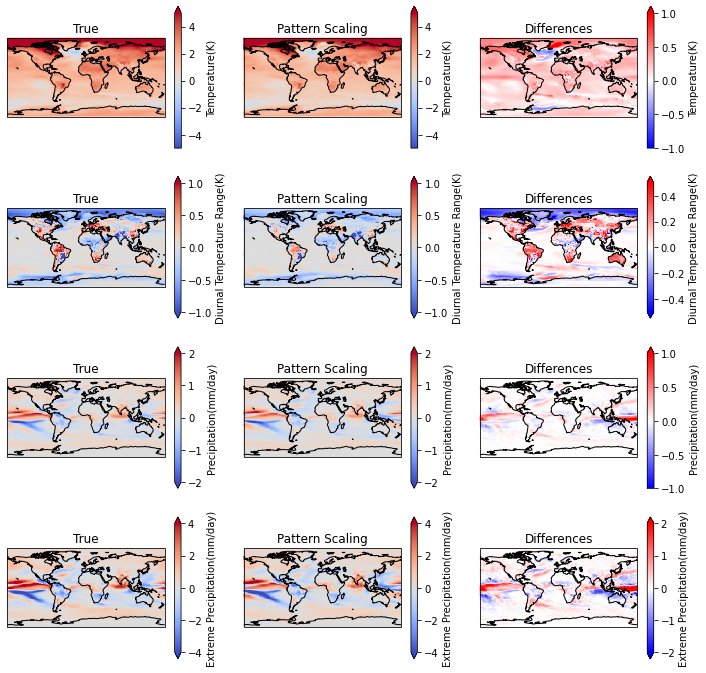

In [30]:
fig = plt.figure(figsize=(12, 12))

for var_num in range(len(output_vars)):
    out = output_vars[var_num]
    for plot_num in range(3):
        if plot_num == 0:
            data = Ytest[out]
        elif plot_num == 1:
            data = xr_output[out]
        else:
            data = Ytest[out] - xr_output[out]
        
        # plot params
        plot_id = 3 * var_num + plot_num + 1
        colormap = "bwr" if plot_num == 2 else "coolwarm"
        
        if plot_num == 0:
            ptitle = 'True'
        elif plot_num == 1:
            ptitle = 'Pattern Scaling'
        else:
            ptitle = 'Differences'
        
        # plot
        ax = plt.subplot(4, 3, plot_id, projection=proj)
        data.sel(time=slice(2050,None)).mean('time').plot(cmap=colormap, vmax=vs[plot_id - 1],
                                      cbar_kwargs={"label":labels[var_num]})
        plt.gca().coastlines()
        plt.setp(plt.gca(), ylabel = 'test1', title=ptitle)  